# CNN model for CIFAR-10 - Object Recognition in Images

[Cifar-10 Benchmark](https://paperswithcode.com/sota/image-classification-on-cifar-10)

Ref.

[CIFAR 10- CNN using PyTorch](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch)

In [54]:
# Python version: 3.10.6

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import pickle
from sklearn import metrics
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [55]:
version = "final"
augmentation = False
training = False
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 100
validation_split = 0.1 if training else 0.0
output_filename = "output-summary-{0}.txt".format(version)
feature = ["batch normalization", "dropout", "add more layers", "fit all training data with no validation split"]
# feature = ["batch normalization", "dropout", "add more layers", "image augmentation"]

## Load dataset

In [56]:
# Using pytorch utils to load dataset
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

training_data = datasets.CIFAR10("data", train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10("data", train=False, download=True, transform=ToTensor())

class_names = training_data.classes
print("Class names of images: ", class_names)

Files already downloaded and verified
Files already downloaded and verified
Class names of images:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [57]:
train_images: np.ndarray = training_data.data
test_images: np.ndarray = test_data.data

train_labels = training_data.targets
test_labels = test_data.targets

## EDA

In [58]:
def plot_cifar10_images(images, n):
    plt.figure(figsize=[10, 10])

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i]])

    plt.show()

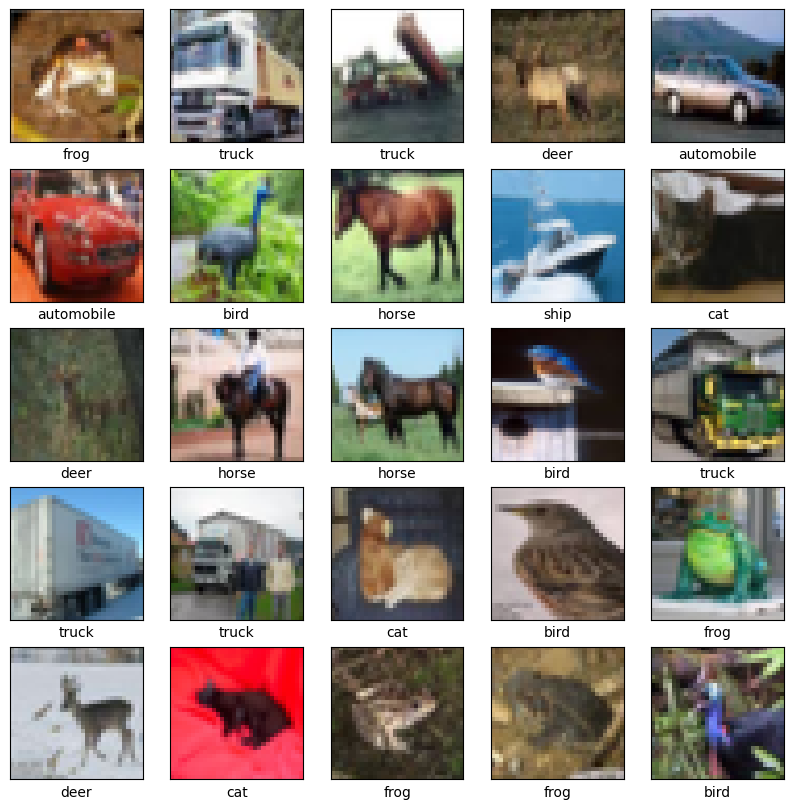

In [59]:
plot_cifar10_images(train_images, 25)

In [60]:
print("train images shape: ", train_images.shape)
print("train labels size: ", len(train_labels))
print("test images shape: ", test_images.shape)
print("test labels size: ", len(test_labels))

train images shape:  (50000, 32, 32, 3)
train labels size:  50000
test images shape:  (10000, 32, 32, 3)
test labels size:  10000


## Data preprocessing

In [61]:
# Image augmentation
# Ref. https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch
# Ref. https://pytorch.org/vision/stable/transforms.html

if augmentation:
    transform_train_image = v2.Compose(
        [
            v2.ToImage(),
            v2.Resize((32, 32)),  # resises the image so it can be perfect for our model.
            v2.RandomHorizontalFlip(p=0.5),  # FLips the image w.r.t horizontal axis
            v2.RandomRotation(10),  # Rotates the image to a specified angel
            v2.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Performs actions like zooms, change shear angles.
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Set the color params
        ]
    )

    train_images_augmentation = np.array([transform_train_image(train_images[i]) for i in range(len(train_images))])

    train_images_augmentation = train_images_augmentation.transpose((0, 2, 3, 1))

    print(train_images_augmentation.shape)
    plot_cifar10_images(train_images_augmentation, 25)

In [62]:
# Join augmented images to train images & do normalization
# Append train labels due to train images augmentation & one-hot encode labels

if augmentation:
    train_images = np.concatenate((train_images, train_images_augmentation)).astype("float32") / 255.0
    train_labels = keras.utils.to_categorical(train_labels + train_labels, num_classes)
else:
    train_images = train_images.astype("float32") / 255.0
    train_labels = keras.utils.to_categorical(train_labels, num_classes)

test_images = test_images.astype("float32") / 255.0
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [63]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Build Convolutional Neural Networks (CNN)

Ref.

[機器學習 - 神經網路 (多層感知機 Multilayer perceptron, MLP) 含倒傳遞 ( Backward propagation) 詳細推導](https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-%E5%A4%9A%E5%B1%A4%E6%84%9F%E7%9F%A5%E6%A9%9F-multilayer-perceptron-mlp-%E5%90%AB%E8%A9%B3%E7%B4%B0%E6%8E%A8%E5%B0%8E-ee4f3d5d1b41)

[卷積神經網絡介紹(Convolutional Neural Network)](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-1%E8%AC%9B-%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E4%BB%8B%E7%B4%B9-convolutional-neural-network-4f8249d65d4f)

![CNN Arch](./images/cnn-arch.png)

Code ref.

僅參考，因為程式碼需要調整
[Step-by-Step Guide to Build CNN Model with Tensorflow](https://www.aitude.com/step-by-step-guide-to-build-cnn-model-with-tensorflow/)

非常有幫助
[Simple Cifar10 CNN Keras code with 88% Accuracy](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy)

In [64]:
# Build a custom CNN model using keras.Model subclassing


class CNN(keras.Model):

    def __init__(self, **kwargs):

        super(CNN, self).__init__()

        # Batch normalization (BN): https://medium.com/ching-i/batch-normalization-%E4%BB%8B%E7%B4%B9-135a24928f12
        # 對每一個 mini-batch 都進行正規化到平均值為0、標準差為1的常態分佈
        # * 減緩梯度消失
        # * 解決 Internal Covariate Shift (ICS) 的問題

        # Dropout: https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E4%BD%BF%E7%94%A8-tensorflow-%E4%BA%86%E8%A7%A3-dropout-bf64a6785431

        self.cnn_layer_1 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        self.batch_normalization_1 = layers.BatchNormalization()

        self.cnn_layer_2 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        self.batch_normalization_2 = layers.BatchNormalization()

        self.pooling_1 = layers.MaxPooling2D((2, 2))
        self.dropout_1 = layers.Dropout(0.3)

        self.cnn_layer_3 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.batch_normalization_3 = layers.BatchNormalization()

        self.cnn_layer_4 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.batch_normalization_4 = layers.BatchNormalization()

        self.pooling_2 = layers.MaxPooling2D((2, 2))
        self.dropout_2 = layers.Dropout(0.5)

        self.cnn_layer_5 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        self.batch_normalization_5 = layers.BatchNormalization()

        self.cnn_layer_6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        self.batch_normalization_6 = layers.BatchNormalization()

        self.pooling_3 = layers.MaxPooling2D((2, 2))
        self.dropout_3 = layers.Dropout(0.5)

        self.flatten = layers.Flatten()

        self.first_dense_layer = layers.Dense(64, activation="relu")

        self.dense_batch_normalization = layers.BatchNormalization()
        self.dense_dropout = layers.Dropout(0.5)

        self.second_dense_layer = layers.Dense(10, activation="softmax")

    def call(self, inputs, training=False):

        x = self.cnn_layer_1(inputs, training=training)
        x = self.batch_normalization_1(x, training=training)

        x = self.cnn_layer_2(x, training=training)
        x = self.batch_normalization_2(x)

        x = self.pooling_1(x)
        x = self.dropout_1(x)

        x = self.cnn_layer_3(x, training=training)
        x = self.batch_normalization_3(x, training=training)

        x = self.cnn_layer_4(x, training=training)
        x = self.batch_normalization_4(x)

        x = self.pooling_2(x)
        x = self.dropout_2(x)

        x = self.cnn_layer_5(x, training=training)
        x = self.batch_normalization_5(x, training=training)

        x = self.cnn_layer_6(x, training=training)
        x = self.batch_normalization_6(x)

        x = self.pooling_3(x)
        x = self.dropout_3(x)

        x = self.flatten(x)

        x = self.first_dense_layer(x, training=training)

        x = self.dense_batch_normalization(x, training=training)
        x = self.dense_dropout(x)

        x = self.second_dense_layer(x, training=training)

        return x

In [65]:
cnn_model = CNN()
cnn_model.build(input_shape=(None, 32, 32, 3))

In [66]:
cnn_model.summary()

Model: "cnn_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          multiple                  896       
                                                                 
 batch_normalization_28 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          multiple                  9248      
                                                                 
 batch_normalization_29 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                             

In [67]:
cnn_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [68]:
train_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=num_epochs,
    verbose=0,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[TqdmCallback(verbose=0)],
)

0epoch [00:00, ?epoch/s]

## Evaluation

In [69]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["loss"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_loss"], "green", linewidth=2.0)
    plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title("Loss Curves", fontsize=12)

In [70]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["accuracy"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_accuracy"], "blue", linewidth=2.0)
    plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Curves", fontsize=12)

In [71]:
# final => accuracy: 0.8728 - loss: 0.4241

if not training:
    test_result = cnn_model.evaluate(test_images, test_labels, batch_size=batch_size)

157/157 [==============================] - 1s 5ms/step - loss: 0.4241 - accuracy: 0.8728


## Save result

In [72]:
f = open("cifar10-cnn-outputs/" + output_filename, "w")

print("batch_size: ".ljust(20), batch_size, file=f)
print("learning_rate: ".ljust(20), learning_rate, file=f)
print("num_epochs: ".ljust(20), num_epochs, file=f)
print("num_classes: ".ljust(20), num_classes, file=f)
print("validation_split: ".ljust(20), validation_split, file=f)
print("training accuracy: ".ljust(20), np.max(train_history.history["accuracy"]), file=f)
print("training loss: ".ljust(20), np.min(train_history.history["loss"]), file=f)

if training:
    print("validation accuracy: ".ljust(20), np.max(train_history.history["val_accuracy"]), file=f)
    print("validation loss: ".ljust(20), np.min(train_history.history["val_loss"]), file=f)

print("feature: ".ljust(20), feature, file=f)

f.close()

In [73]:
keras.models.save_model(cnn_model, "./models/cifar10-cnn-{0}".format(version), save_format="tf")

INFO:tensorflow:Assets written to: ./models/cifar10-cnn-final\assets


INFO:tensorflow:Assets written to: ./models/cifar10-cnn-final\assets


In [74]:
with open("./models/cifar10-cnn-{0}-history".format(version), "wb") as f:
    pickle.dump(train_history.history, f)

## Final prediction

In [75]:
assert not training, "Training mode can't do final prediction"

cnn_final_model = keras.models.load_model("./models/cifar10-cnn-{0}".format(version), custom_objects={"CNN": CNN})

pred = cnn_final_model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

313/313 [==============================] - 1s 3ms/step


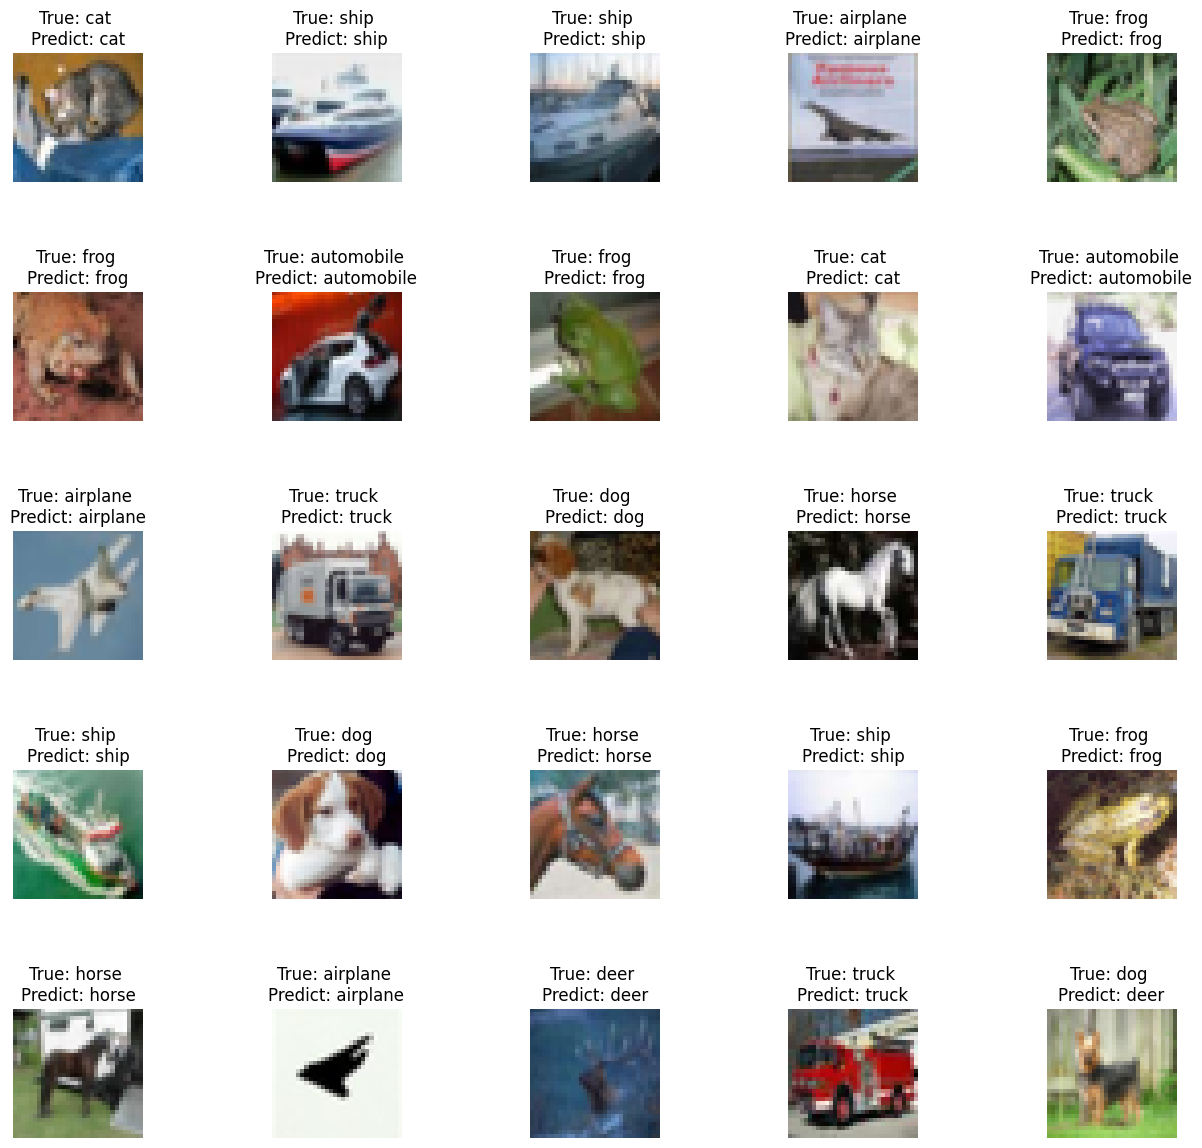

In [76]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_labels[i]]))
    axes[i].axis("off")
    plt.subplots_adjust(wspace=1)

## Test result insights

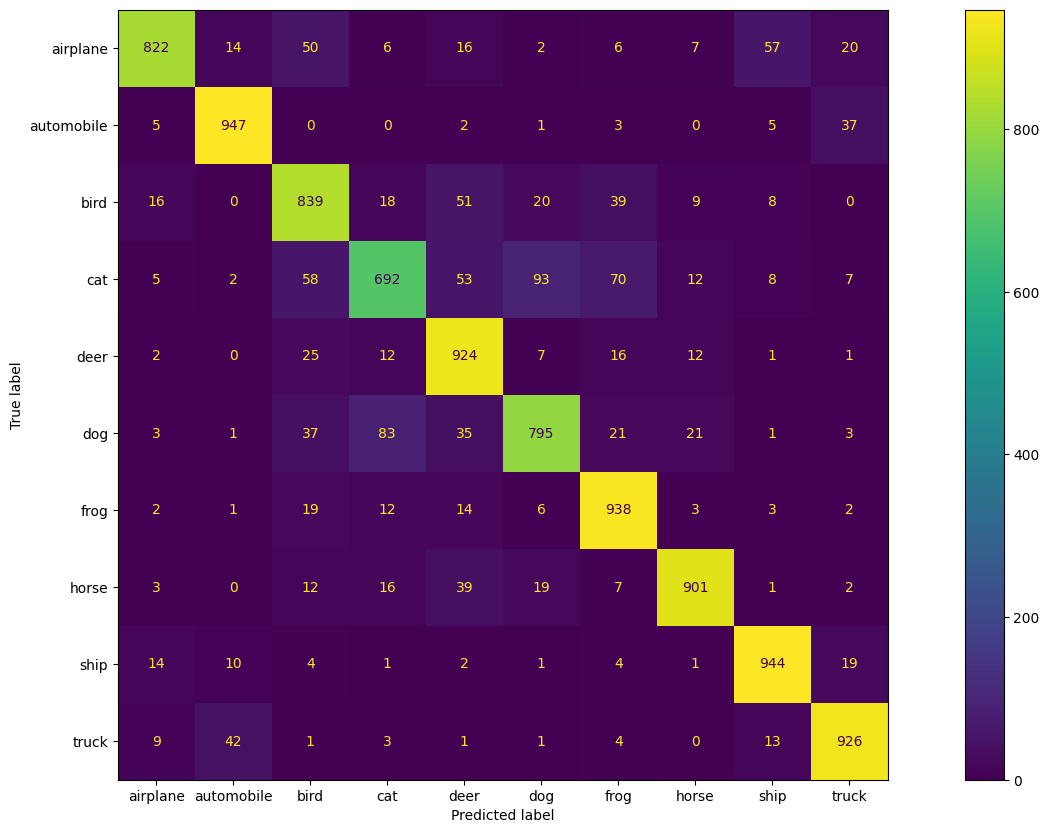

In [77]:
confusion_metrics = metrics.confusion_matrix(np.argmax(test_labels, axis=1), pred_labels)
display = metrics.ConfusionMatrixDisplay(confusion_metrics, display_labels=class_names)
fig, axes = plt.subplots(figsize=(20, 10))
display.plot(ax=axes)
plt.show()

In [78]:
print(metrics.classification_report(np.argmax(test_labels, axis=1), pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.93      0.82      0.87      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.80      0.84      0.82      1000
         cat       0.82      0.69      0.75      1000
        deer       0.81      0.92      0.86      1000
         dog       0.84      0.80      0.82      1000
        frog       0.85      0.94      0.89      1000
       horse       0.93      0.90      0.92      1000
        ship       0.91      0.94      0.93      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

